# BatchNorm Model

In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
os.chdir("../models")

import pickle
import torch
import torch.nn as nn
import torchvision

from common_utils import set_seed, EarlyStopper, train, get_mean_rgb, test_model
from datetime import datetime
from model import BatchNormCNN
from sklearn.metrics import top_k_accuracy_score, f1_score
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Set up variables, seed and pytorch device

In [2]:
# We might want to run the notebook with different parameters using a script
# Use environment varables to set the parameters if thats the case
defaults = {
    "model_name": "BatchNormCNN",
    "model_seed": 42,
    "batchnorm_moment": 0.05
    
}
for k, v in defaults.items():
    globals()[k] = os.environ.get(k, defaults[k])
    # Use default value type to infer the variable type
    if isinstance(v, int):
        globals()[k] = int(globals()[k])
    elif isinstance(v, float):
        globals()[k] = float(globals()[k])

# set seed
set_seed(model_seed)

device_type = None
device = None
# determine device type
if torch.cuda.is_available(): # nvidia gpu
    device = torch.device("cuda")
    device_type = "cuda"
elif torch.backends.mps.is_available(): # apple gpu
    device = torch.device("mps")
    device_type = "mps"
else:
    device = torch.device("cpu")
    device_type = "mps"

[globals()[k] for k in defaults.keys()], device_type

(['BatchNormCNN', 42, 0.05], 'cuda')

### Initialise model

In [3]:
model = BatchNormCNN(batchnorm_moment=batchnorm_moment).to(device_type) # initialise model
data_dir_path = "../data"

# Make directory to save baseline model
# Don't overwrite exisiting models and model outputs
model_path = f"./saved_models/{model_name}/"
if not os.path.exists(model_path):
    os.makedirs(model_path, exist_ok=True)
else:
    raise Exception('''
        Directory already exists. Either choose a different 'model_name' or
        delete the exisiting directory.
    ''')

# Construct the full path
device_path = os.path.join(model_path, device_type)

# Create the directory if it doesn't exist
if not os.path.exists(device_path):
    os.mkdir(device_path)

### Initialise Dataset

In [4]:
data_path = "../data"

batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100, 100), antialias=True),
])

# load data
# NOTE: Due to a bug with the Flowers102 dataset, the train and test splits are swapped
train_dataset = datasets.Flowers102(root=data_path,
                                    split='test',
                                    download=True,
                                    transform=transform
                                   ) 
val_dataset = datasets.Flowers102(root=data_path,
                                  split='val',
                                  download=True,
                                  transform=transform
                                 ) 
test_dataset = datasets.Flowers102(root=data_path,
                                   split='train',
                                   download=True,
                                   transform=transform
                                  )

# initialise dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Specify hyperparameters

In [5]:
lr = 0.001 # learning rate
optimiser = torch.optim.Adam(model.parameters(), lr=lr) # initialise optimiser
loss = torch.nn.CrossEntropyLoss() # initialise loss function
epochs = 100
patience = 15

early_stopper = EarlyStopper(patience=patience) # initialise early stopper

### Train the model

In [6]:
out = train(model, train_dataloader, val_dataloader, optimiser,
            loss, device, epochs, early_stopper, device_path
           )
train_loss_list, val_loss_list, val_acc_list, train_time_list, early_stop = out

Epoch 1/100: 100%|██████████| 49/49 [00:32<00:00,  1.52it/s, Training loss=3.8148, Learning rate=0.00100]


Epoch 1/100 took 36.59s | Train loss: 3.8148 | Val loss: 4.0173 | Val accuracy: 6.76% | EarlyStopper count: 0


Epoch 2/100: 100%|██████████| 49/49 [00:29<00:00,  1.64it/s, Training loss=3.1159, Learning rate=0.00100]


Epoch 2/100 took 34.06s | Train loss: 3.1159 | Val loss: 3.2282 | Val accuracy: 17.16% | EarlyStopper count: 0


Epoch 3/100: 100%|██████████| 49/49 [00:29<00:00,  1.64it/s, Training loss=2.6751, Learning rate=0.00100]


Epoch 3/100 took 34.18s | Train loss: 2.6751 | Val loss: 4.2559 | Val accuracy: 11.08% | EarlyStopper count: 0


Epoch 4/100: 100%|██████████| 49/49 [00:29<00:00,  1.63it/s, Training loss=2.8999, Learning rate=0.00100]


Epoch 4/100 took 34.04s | Train loss: 2.8999 | Val loss: 3.7106 | Val accuracy: 16.76% | EarlyStopper count: 1


Epoch 5/100: 100%|██████████| 49/49 [00:30<00:00,  1.61it/s, Training loss=2.6907, Learning rate=0.00100]


Epoch 5/100 took 34.53s | Train loss: 2.6907 | Val loss: 2.7411 | Val accuracy: 26.47% | EarlyStopper count: 2


Epoch 6/100: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s, Training loss=2.3598, Learning rate=0.00100]


Epoch 6/100 took 34.64s | Train loss: 2.3598 | Val loss: 2.4949 | Val accuracy: 32.06% | EarlyStopper count: 0


Epoch 7/100: 100%|██████████| 49/49 [00:29<00:00,  1.64it/s, Training loss=2.1288, Learning rate=0.00100]


Epoch 7/100 took 34.12s | Train loss: 2.1288 | Val loss: 2.6968 | Val accuracy: 28.24% | EarlyStopper count: 0


Epoch 8/100: 100%|██████████| 49/49 [00:30<00:00,  1.61it/s, Training loss=2.0469, Learning rate=0.00100]


Epoch 8/100 took 34.68s | Train loss: 2.0469 | Val loss: 3.0756 | Val accuracy: 26.08% | EarlyStopper count: 1


Epoch 9/100: 100%|██████████| 49/49 [00:29<00:00,  1.68it/s, Training loss=2.2553, Learning rate=0.00100]


Epoch 9/100 took 32.96s | Train loss: 2.2553 | Val loss: 2.2071 | Val accuracy: 38.73% | EarlyStopper count: 2


Epoch 10/100: 100%|██████████| 49/49 [00:29<00:00,  1.69it/s, Training loss=1.8317, Learning rate=0.00100]


Epoch 10/100 took 33.17s | Train loss: 1.8317 | Val loss: 2.1070 | Val accuracy: 43.43% | EarlyStopper count: 0


Epoch 11/100: 100%|██████████| 49/49 [00:29<00:00,  1.68it/s, Training loss=1.6965, Learning rate=0.00100]


Epoch 11/100 took 33.19s | Train loss: 1.6965 | Val loss: 2.1701 | Val accuracy: 39.61% | EarlyStopper count: 0


Epoch 12/100: 100%|██████████| 49/49 [00:28<00:00,  1.70it/s, Training loss=1.6636, Learning rate=0.00100]


Epoch 12/100 took 32.84s | Train loss: 1.6636 | Val loss: 1.9811 | Val accuracy: 45.88% | EarlyStopper count: 1


Epoch 13/100: 100%|██████████| 49/49 [00:28<00:00,  1.70it/s, Training loss=1.5114, Learning rate=0.00100]


Epoch 13/100 took 32.90s | Train loss: 1.5114 | Val loss: 1.7612 | Val accuracy: 50.49% | EarlyStopper count: 0


Epoch 14/100: 100%|██████████| 49/49 [00:29<00:00,  1.69it/s, Training loss=1.3568, Learning rate=0.00100]


Epoch 14/100 took 33.00s | Train loss: 1.3568 | Val loss: 2.3062 | Val accuracy: 38.33% | EarlyStopper count: 0


Epoch 15/100: 100%|██████████| 49/49 [00:28<00:00,  1.70it/s, Training loss=1.9828, Learning rate=0.00100]


Epoch 15/100 took 32.89s | Train loss: 1.9828 | Val loss: 2.5832 | Val accuracy: 36.18% | EarlyStopper count: 1


Epoch 16/100: 100%|██████████| 49/49 [00:28<00:00,  1.71it/s, Training loss=1.8643, Learning rate=0.00100]


Epoch 16/100 took 32.69s | Train loss: 1.8643 | Val loss: 2.5599 | Val accuracy: 32.65% | EarlyStopper count: 2


Epoch 17/100: 100%|██████████| 49/49 [00:28<00:00,  1.72it/s, Training loss=1.6782, Learning rate=0.00100]


Epoch 17/100 took 32.45s | Train loss: 1.6782 | Val loss: 1.7663 | Val accuracy: 51.96% | EarlyStopper count: 3


Epoch 18/100: 100%|██████████| 49/49 [00:28<00:00,  1.71it/s, Training loss=1.3331, Learning rate=0.00100]


Epoch 18/100 took 32.66s | Train loss: 1.3331 | Val loss: 2.2863 | Val accuracy: 38.63% | EarlyStopper count: 4


Epoch 19/100: 100%|██████████| 49/49 [00:28<00:00,  1.70it/s, Training loss=1.7468, Learning rate=0.00100]


Epoch 19/100 took 32.92s | Train loss: 1.7468 | Val loss: 1.7571 | Val accuracy: 50.39% | EarlyStopper count: 5


Epoch 20/100: 100%|██████████| 49/49 [00:29<00:00,  1.68it/s, Training loss=1.3594, Learning rate=0.00100]


Epoch 20/100 took 33.14s | Train loss: 1.3594 | Val loss: 2.0363 | Val accuracy: 44.90% | EarlyStopper count: 0


Epoch 21/100: 100%|██████████| 49/49 [00:28<00:00,  1.71it/s, Training loss=1.5979, Learning rate=0.00100]


Epoch 21/100 took 32.77s | Train loss: 1.5979 | Val loss: 2.5413 | Val accuracy: 38.24% | EarlyStopper count: 1


Epoch 22/100: 100%|██████████| 49/49 [00:29<00:00,  1.69it/s, Training loss=2.2328, Learning rate=0.00100]


Epoch 22/100 took 33.19s | Train loss: 2.2328 | Val loss: 2.1737 | Val accuracy: 40.88% | EarlyStopper count: 2


Epoch 23/100: 100%|██████████| 49/49 [00:29<00:00,  1.67it/s, Training loss=1.6751, Learning rate=0.00100]


Epoch 23/100 took 33.55s | Train loss: 1.6751 | Val loss: 1.7020 | Val accuracy: 53.04% | EarlyStopper count: 3


Epoch 24/100: 100%|██████████| 49/49 [00:29<00:00,  1.68it/s, Training loss=1.4030, Learning rate=0.00100]


Epoch 24/100 took 33.24s | Train loss: 1.4030 | Val loss: 3.7059 | Val accuracy: 27.75% | EarlyStopper count: 0


Epoch 25/100: 100%|██████████| 49/49 [00:29<00:00,  1.69it/s, Training loss=2.2668, Learning rate=0.00100]


Epoch 25/100 took 33.11s | Train loss: 2.2668 | Val loss: 3.3045 | Val accuracy: 24.02% | EarlyStopper count: 1


Epoch 26/100: 100%|██████████| 49/49 [00:29<00:00,  1.67it/s, Training loss=2.8948, Learning rate=0.00100]


Epoch 26/100 took 33.44s | Train loss: 2.8948 | Val loss: 2.4862 | Val accuracy: 32.94% | EarlyStopper count: 2


Epoch 27/100: 100%|██████████| 49/49 [00:29<00:00,  1.67it/s, Training loss=1.9346, Learning rate=0.00100]


Epoch 27/100 took 33.41s | Train loss: 1.9346 | Val loss: 2.0052 | Val accuracy: 45.00% | EarlyStopper count: 3


Epoch 28/100: 100%|██████████| 49/49 [00:29<00:00,  1.67it/s, Training loss=1.6843, Learning rate=0.00100]


Epoch 28/100 took 33.49s | Train loss: 1.6843 | Val loss: 1.8986 | Val accuracy: 49.12% | EarlyStopper count: 4


Epoch 29/100: 100%|██████████| 49/49 [00:29<00:00,  1.69it/s, Training loss=1.6643, Learning rate=0.00100]


Epoch 29/100 took 33.15s | Train loss: 1.6643 | Val loss: 1.8666 | Val accuracy: 49.71% | EarlyStopper count: 5


Epoch 30/100: 100%|██████████| 49/49 [00:29<00:00,  1.67it/s, Training loss=1.4433, Learning rate=0.00100]


Epoch 30/100 took 33.78s | Train loss: 1.4433 | Val loss: 1.7281 | Val accuracy: 53.63% | EarlyStopper count: 6


Epoch 31/100: 100%|██████████| 49/49 [00:29<00:00,  1.65it/s, Training loss=1.4104, Learning rate=0.00100]


Epoch 31/100 took 33.95s | Train loss: 1.4104 | Val loss: 1.6025 | Val accuracy: 55.98% | EarlyStopper count: 7


Epoch 32/100: 100%|██████████| 49/49 [00:29<00:00,  1.65it/s, Training loss=1.2630, Learning rate=0.00100]


Epoch 32/100 took 33.98s | Train loss: 1.2630 | Val loss: 1.5565 | Val accuracy: 55.88% | EarlyStopper count: 0


Epoch 33/100: 100%|██████████| 49/49 [00:29<00:00,  1.67it/s, Training loss=1.1355, Learning rate=0.00100]


Epoch 33/100 took 33.33s | Train loss: 1.1355 | Val loss: 1.5538 | Val accuracy: 57.84% | EarlyStopper count: 0


Epoch 34/100: 100%|██████████| 49/49 [00:29<00:00,  1.64it/s, Training loss=1.0770, Learning rate=0.00100]


Epoch 34/100 took 34.24s | Train loss: 1.0770 | Val loss: 1.6513 | Val accuracy: 55.10% | EarlyStopper count: 0


Epoch 35/100: 100%|██████████| 49/49 [00:29<00:00,  1.67it/s, Training loss=1.1241, Learning rate=0.00100]


Epoch 35/100 took 33.47s | Train loss: 1.1241 | Val loss: 1.5193 | Val accuracy: 57.25% | EarlyStopper count: 1


Epoch 36/100: 100%|██████████| 49/49 [00:29<00:00,  1.67it/s, Training loss=0.9887, Learning rate=0.00100]


Epoch 36/100 took 33.60s | Train loss: 0.9887 | Val loss: 1.4672 | Val accuracy: 60.29% | EarlyStopper count: 0


Epoch 37/100: 100%|██████████| 49/49 [00:29<00:00,  1.69it/s, Training loss=1.0484, Learning rate=0.00100]


Epoch 37/100 took 33.22s | Train loss: 1.0484 | Val loss: 1.4782 | Val accuracy: 59.61% | EarlyStopper count: 0


Epoch 38/100: 100%|██████████| 49/49 [00:29<00:00,  1.66it/s, Training loss=0.9627, Learning rate=0.00100]


Epoch 38/100 took 33.74s | Train loss: 0.9627 | Val loss: 2.2150 | Val accuracy: 42.65% | EarlyStopper count: 1


Epoch 39/100: 100%|██████████| 49/49 [00:29<00:00,  1.67it/s, Training loss=2.0028, Learning rate=0.00100]


Epoch 39/100 took 33.57s | Train loss: 2.0028 | Val loss: 1.7946 | Val accuracy: 51.18% | EarlyStopper count: 2


Epoch 40/100: 100%|██████████| 49/49 [00:29<00:00,  1.65it/s, Training loss=1.3619, Learning rate=0.00100]


Epoch 40/100 took 33.99s | Train loss: 1.3619 | Val loss: 1.6071 | Val accuracy: 55.69% | EarlyStopper count: 3


Epoch 41/100: 100%|██████████| 49/49 [00:29<00:00,  1.65it/s, Training loss=1.0511, Learning rate=0.00100]


Epoch 41/100 took 33.83s | Train loss: 1.0511 | Val loss: 1.4992 | Val accuracy: 59.02% | EarlyStopper count: 4


Epoch 42/100: 100%|██████████| 49/49 [00:29<00:00,  1.67it/s, Training loss=0.9934, Learning rate=0.00100]


Epoch 42/100 took 33.50s | Train loss: 0.9934 | Val loss: 1.5002 | Val accuracy: 59.12% | EarlyStopper count: 5


Epoch 43/100: 100%|██████████| 49/49 [00:29<00:00,  1.66it/s, Training loss=0.9176, Learning rate=0.00100]


Epoch 43/100 took 33.88s | Train loss: 0.9176 | Val loss: 1.4249 | Val accuracy: 61.76% | EarlyStopper count: 6


Epoch 44/100: 100%|██████████| 49/49 [00:29<00:00,  1.68it/s, Training loss=0.8302, Learning rate=0.00100]


Epoch 44/100 took 33.33s | Train loss: 0.8302 | Val loss: 1.4810 | Val accuracy: 59.31% | EarlyStopper count: 0


Epoch 45/100: 100%|██████████| 49/49 [00:28<00:00,  1.69it/s, Training loss=1.0053, Learning rate=0.00100]


Epoch 45/100 took 32.73s | Train loss: 1.0053 | Val loss: 1.5033 | Val accuracy: 59.51% | EarlyStopper count: 1


Epoch 46/100: 100%|██████████| 49/49 [00:29<00:00,  1.67it/s, Training loss=0.7795, Learning rate=0.00100]


Epoch 46/100 took 33.41s | Train loss: 0.7795 | Val loss: 1.3724 | Val accuracy: 63.82% | EarlyStopper count: 2


Epoch 47/100: 100%|██████████| 49/49 [00:29<00:00,  1.67it/s, Training loss=0.7614, Learning rate=0.00100]


Epoch 47/100 took 33.43s | Train loss: 0.7614 | Val loss: 1.9030 | Val accuracy: 50.49% | EarlyStopper count: 0


Epoch 48/100: 100%|██████████| 49/49 [00:29<00:00,  1.68it/s, Training loss=1.7454, Learning rate=0.00100]


Epoch 48/100 took 33.35s | Train loss: 1.7454 | Val loss: 2.7971 | Val accuracy: 37.65% | EarlyStopper count: 1


Epoch 49/100: 100%|██████████| 49/49 [00:29<00:00,  1.66it/s, Training loss=2.7887, Learning rate=0.00100]


Epoch 49/100 took 33.68s | Train loss: 2.7887 | Val loss: 2.3180 | Val accuracy: 39.80% | EarlyStopper count: 2


Epoch 50/100: 100%|██████████| 49/49 [00:29<00:00,  1.67it/s, Training loss=1.6596, Learning rate=0.00100]


Epoch 50/100 took 33.60s | Train loss: 1.6596 | Val loss: 1.7611 | Val accuracy: 52.55% | EarlyStopper count: 3


Epoch 51/100: 100%|██████████| 49/49 [00:29<00:00,  1.66it/s, Training loss=1.3553, Learning rate=0.00100]


Epoch 51/100 took 33.67s | Train loss: 1.3553 | Val loss: 1.6445 | Val accuracy: 54.61% | EarlyStopper count: 4


Epoch 52/100: 100%|██████████| 49/49 [00:29<00:00,  1.68it/s, Training loss=1.0796, Learning rate=0.00100]


Epoch 52/100 took 33.36s | Train loss: 1.0796 | Val loss: 1.5949 | Val accuracy: 57.06% | EarlyStopper count: 5


Epoch 53/100: 100%|██████████| 49/49 [00:29<00:00,  1.67it/s, Training loss=1.0018, Learning rate=0.00100]


Epoch 53/100 took 33.74s | Train loss: 1.0018 | Val loss: 1.5063 | Val accuracy: 59.51% | EarlyStopper count: 6


Epoch 54/100: 100%|██████████| 49/49 [00:30<00:00,  1.63it/s, Training loss=0.9048, Learning rate=0.00100]


Epoch 54/100 took 34.37s | Train loss: 0.9048 | Val loss: 1.4553 | Val accuracy: 60.20% | EarlyStopper count: 7


Epoch 55/100: 100%|██████████| 49/49 [00:29<00:00,  1.66it/s, Training loss=0.8324, Learning rate=0.00100]


Epoch 55/100 took 33.88s | Train loss: 0.8324 | Val loss: 1.4731 | Val accuracy: 59.71% | EarlyStopper count: 8


Epoch 56/100: 100%|██████████| 49/49 [00:30<00:00,  1.63it/s, Training loss=0.7715, Learning rate=0.00100]


Epoch 56/100 took 34.10s | Train loss: 0.7715 | Val loss: 1.4700 | Val accuracy: 60.98% | EarlyStopper count: 9


Epoch 57/100: 100%|██████████| 49/49 [00:29<00:00,  1.66it/s, Training loss=0.7156, Learning rate=0.00100]


Epoch 57/100 took 33.80s | Train loss: 0.7156 | Val loss: 1.4130 | Val accuracy: 62.65% | EarlyStopper count: 10


Epoch 58/100: 100%|██████████| 49/49 [00:29<00:00,  1.64it/s, Training loss=0.7477, Learning rate=0.00100]


Epoch 58/100 took 34.21s | Train loss: 0.7477 | Val loss: 1.3847 | Val accuracy: 63.24% | EarlyStopper count: 11


Epoch 59/100: 100%|██████████| 49/49 [00:30<00:00,  1.63it/s, Training loss=0.6115, Learning rate=0.00100]


Epoch 59/100 took 34.12s | Train loss: 0.6115 | Val loss: 1.4964 | Val accuracy: 62.45% | EarlyStopper count: 12


Epoch 60/100: 100%|██████████| 49/49 [00:29<00:00,  1.67it/s, Training loss=0.7743, Learning rate=0.00100]


Epoch 60/100 took 33.41s | Train loss: 0.7743 | Val loss: 1.4272 | Val accuracy: 62.06% | EarlyStopper count: 13


Epoch 61/100: 100%|██████████| 49/49 [00:28<00:00,  1.69it/s, Training loss=0.6370, Learning rate=0.00100]


Epoch 61/100 took 33.17s | Train loss: 0.6370 | Val loss: 1.4334 | Val accuracy: 61.37% | EarlyStopper count: 14
Early stopping


### Plot train, test loss and test accuracy
Note that this is only to visualize how the training was. We will create nicer plots for the report.

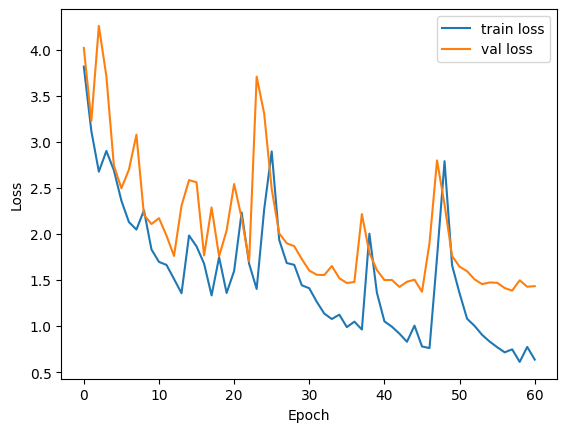

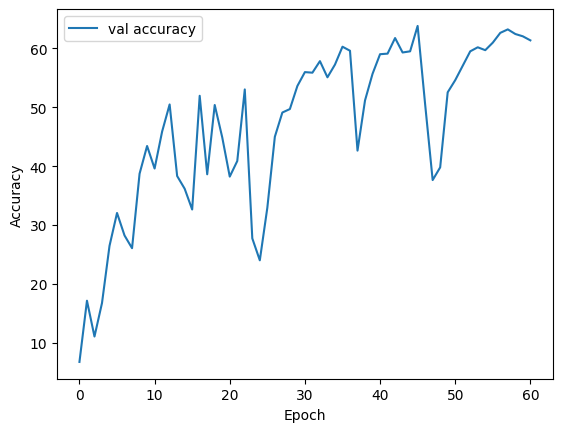

In [7]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list, label="train loss")
plt.plot(val_loss_list, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(val_acc_list, label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

### Model Evaluation with test data

In [8]:
checkpoint = torch.load(os.path.join(device_path, 'best_model.pt'))

best_model = BatchNormCNN().to(device_type)
best_model.load_state_dict(checkpoint)

true_labels = torch.stack([label for _, label in test_dataloader])
pred_softmax_labels = test_model(best_model, test_dataloader, loss, device).cpu()
pred_labels = torch.argmax(pred_softmax_labels, dim=1)

top_1_accuracy = top_k_accuracy_score(true_labels, pred_softmax_labels, k=1)
top_5_accuracy = top_k_accuracy_score(true_labels, pred_softmax_labels, k=5)
f1 = f1_score(true_labels, pred_labels, average='micro')

top_1_accuracy, top_5_accuracy, f1

(0.6245098039215686, 0.8598039215686275, 0.6245098039215686)

### Save all relevant data/parameters to be used for plots, etc
Note that different models may have the same parameters. There's no guarantee that they can be accessible across different computers. There may also be some redundant parameters added just in case we might need them.

In [9]:
data = {
    "time_trained": datetime.now().strftime("%D,%H:%M:%S"),
    "model_name": model_name,
    "model_seed": model_seed,
    "device_type": device_type,
    
    "model": model,
    "batch_size": batch_size,
    "transform": transform,
    
    "lr": lr,
    "epochs": epochs,
    "patience": patience,
    
    "train_loss_list": train_loss_list,
    "val_loss_list": val_loss_list,
    "val_acc_list": val_acc_list,
    "train_time_list": train_time_list,
    "early_stop": early_stop,   # Boolean for if early stopping happened

    "true_labels": true_labels,
    "pred_softmax_labels": pred_softmax_labels,
    "pred_labels": pred_labels,
    "top_1_accuracy": top_1_accuracy,
    "top_5_accuracy": top_5_accuracy,
    "f1": f1,

    "batchnorm_moment": batchnorm_moment
}

with open(os.path.join(model_path, "data.pickle"), "wb") as f: 
    pickle.dump(data, f)